### Activamos multi-threading en VSCode con JupyterNotebook

+ [https://docs.julialang.org/en/v1/manual/multi-threading/](https://docs.julialang.org/en/v1/manual/multi-threading/)
+ [https://enccs.github.io/Julia-for-HPC/multithreading/](https://enccs.github.io/Julia-for-HPC/multithreading/)
+ [https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks](https://stackoverflow.com/questions/71596187/changing-threads-in-settings-json-of-vs-code-for-julias-jupyter-notebooks)

In [5]:
println("Number of threads = ", Threads.nthreads());

Number of threads = 4


# Objetivos del Jupiter Notebook

Este Notebook se diseño para comenzar a testear los algoritmos propuestos. Para ello se consideró el caso más simple posible, es decir, sin factor de acoplamiento $\gamma = 0$ y el 1er método de resolución (leer capítulo 2 del informe).

In [1]:
include("../modules/module_schrodinger_equation_testing_01.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/pde2022/final_project/gridap_makie`


VARIABLES GLOBALES:
m=1.0000 (mass)
ω=1.0000 (frecuency)
ħ=1.0000 (Planck constant)
γ=0.0000 (coupling)


x₁=0.0000 x₂=2.0000 y₁=0.0000 y₂=2.0000 (QHO origin position)


Acá resolvemos el problema de autovalores para el hamiltoniano individual $\hat{h}_{x_{a}}( x) \phi ( x) =\lambda \phi ( x)$. Entonces, tendremos una ecuación similar de Sturm-Liouville con parámetros $p(x)$,$q(x)$,$r(x)$ definidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar^{2}}{2m}\\
    q( x) =\left(\frac{m\omega ^{2}( x-x_{a})^{2}}{2} +\gamma \right)\\
    r( x) =1
    \end{cases} \Rightarrow \left[ -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\right] u( x) =\lambda r( x) u( x)
\end{align}

Las formas bilineales para considerar el problema débil de autovalores serán de la forma

\begin{align}
        a( u,v) &:= \int _{\Omega }[ p( x) \nabla v( x) \cdotp \nabla u( x) +q( x) v( x) u( x)] d\Omega \\
        b( u,v) &:= \int _{\Omega } r( x) u( x) v( x) d\Omega
\end{align}

aquí las funciones Test $v(x)$ y Trial $u(x)$ viven cada una en un espacio complejo.

In [2]:
grid_type="simple_line";                            # tipo de grilla
Δxₕ=1.0/200.0;                                      # tamaño del elento 1D

dom_1D=(-25.0,25.0);

par_1D=(path_models,grid_type*"_01",dom_1D,Δxₕ);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo
write_data=false
if write_data
    writevtk(model_1D,path_images*"model_1D");      # escribimos el modelo para visualizar con Visit
end

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0066912s, CPU 0.005408s)
Info    : 10001 nodes 10002 elements
Info    : Writing '../models/simple_line_01.msh'...
Info    : Done writing '../models/simple_line_01.msh'
Info    : Reading '../models/simple_line_01.msh'...
Info    : 3 entities
Info    : 10001 nodes
Info    : 10002 elements
Info    : Done reading '../models/simple_line_01.msh'


### Definimos condiciones de contorno (de tipo full Dirichlet, es decir, homogéneas en los bordes)

In [3]:
# condiciones de contorno
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[(0.0+im*0.0),(0.0+im*0.0)];

### Creamos triangulación del dominio de integración y del borde

In [4]:
Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);

### Creamos espacio de referencia para los elementos finitos

In [5]:
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

### Definimos espacio de prueba y espacio de solución

In [6]:
Vₕ_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕ_1D=TrialFESpace(Vₕ_1D,dirichlet_values_1D);

### Definimos formas bilineales para el problema débil

+ Weak Form of the Effective Mass Schrodinger Equation
+ Reference: [https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/](https://www.physicsforums.com/threads/weak-form-of-the-effective-mass-schrodinger-equation.751282/)

In [7]:
aₕ_1D,bₕ_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);

### Resolvemos el problema débil de autovalores

In [8]:
nevₕ=20 # number of eigenvalues asked to evaluate.
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕ_1D,Vₕ_1D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

### Ahora hacemos lo mismo para dominios de distintos largos y vemos cómo afecta esto a las autoenergías

In [23]:
# dominio (punto izquierdo y punto derecho)
dom_1D₁=(-1.0,1.0);
dom_1D₂=(-5.0,5.0);

In [24]:
par_1D_dom_1D₁=(path_models,grid_type*"_dom1D1",dom_1D₁,Δxₕ);    # (path,name,dom,MeshSize)
model_1D_dom_1D₁=make_model(grid_type,par_1D_dom_1D₁);                  # creamos modelo
Ω_1D_dom_1D₁,dΩ_1D_dom_1D₁,Γ_1D_dom_1D₁,dΓ_1D_dom_1D₁=measures(model_1D_dom_1D₁,3,dirichlet_tags_1D);
Vₕ_1D_dom_1D₁=TestFESpace(model_1D_dom_1D₁,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕ_1D_dom_1D₁=TrialFESpace(Vₕ_1D_dom_1D₁,dirichlet_values_1D);
aₕ_1D_dom_1D₁,bₕ_1D_dom_1D₁=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D_dom_1D₁);
nevₕ=20 # number of eigenvalues asked to evaluate.
probₕ_1D_dom_1D₁=EigenProblem(aₕ_1D_dom_1D₁,bₕ_1D_dom_1D₁,Uₕ_1D_dom_1D₁,Vₕ_1D_dom_1D₁;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_1D_dom_1D₁,ϕₕ_1D_dom_1D₁=solve(probₕ_1D_dom_1D₁);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.000414405s, CPU 0.000406s)
Info    : 401 nodes 402 elements
Info    : Writing '../models/simple_line_dom1D1.msh'...
Info    : Done writing '../models/simple_line_dom1D1.msh'
Info    : Reading '../models/simple_line_dom1D1.msh'...
Info    : 3 entities
Info    : 401 nodes
Info    : 402 elements
Info    : Done reading '../models/simple_line_dom1D1.msh'


### Graficamos los autovalores

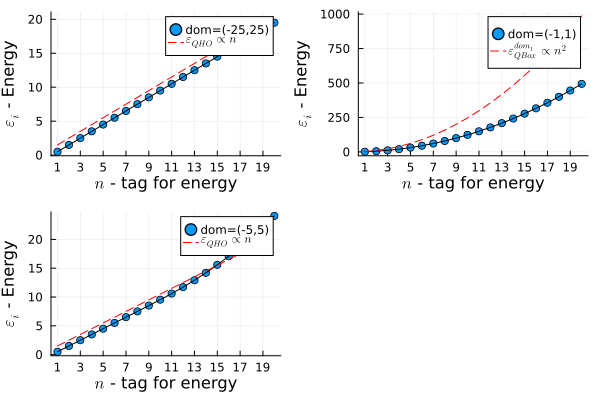

In [38]:
n=[1.0*i for i in 1:nevₕ];

plot1=scatter(n,real(ϵₕ_1D),label="dom=(-25,25)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
plot1=plot!(n,real(ϵₕ_1D),label="",lc=:"black",lw=1)
plot1=plot!(n,(ħ*ω).*(n.+0.5),label="\$\\epsilon_{QHO} \\propto n\$",lc=:"red",lw=1,ls=:dash);

plot2=scatter(n,real(ϵₕ_1D_dom_1D₁),label="dom=(-1,1)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2);
plot2=plot!(n,real(ϵₕ_1D_dom_1D₁),label="",lc=:"black",lw=1)
plot2=plot!(n,(ħ*ħ*π*π*0.5/(m*2.0)).*(n.^2),label="\$\\epsilon_{QBox}^{dom_{1}} \\propto n^2\$",lc=:"red",lw=1,ls=:dash);

plot3=scatter(n,real(ϵₕ_1D_dom_1D₂),label="dom=(-5,5)",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2);
plot3=plot!(n,real(ϵₕ_1D_dom_1D₂),label="",lc=:"black",lw=1)
plot3=plot!(n,(ħ*ω).*(n.+0.5),label="\$\\epsilon_{QHO} \\propto n\$",lc=:"red",lw=1,ls=:dash);

plot4=plot(plot1,plot2,plot3,layout=3)
savefig(plot4,path_plots*"enegies_eigenproblem_1D.pdf");
display(plot4);

Aquí podemos ver la influencia del dominio de la caja donde se intenta resolver el problema de autovalores con las autoenergías obtenidas.

Notamos que, a medida que disminuimos el dominio de integración, los autoestados de la caja se hacen más evidentes y, en determinado momento, predominan por sobre los del oscilador armónico. Por ello, optamos por elegir el dominio más grande, de tal forma de asegurarnos que las autoenergías obtenidas sean efectiamente los más parecidos a los del oscilador armónico.

### Graficamos las autofunciones

+ [https://arxiv.org/pdf/1910.01412v2.pdf](https://arxiv.org/pdf/1910.01412v2.pdf)
+ [https://gridap.github.io/Tutorials/dev/pages/t015_interpolation_fe/](https://gridap.github.io/Tutorials/dev/pages/t015_interpolation_fe/)

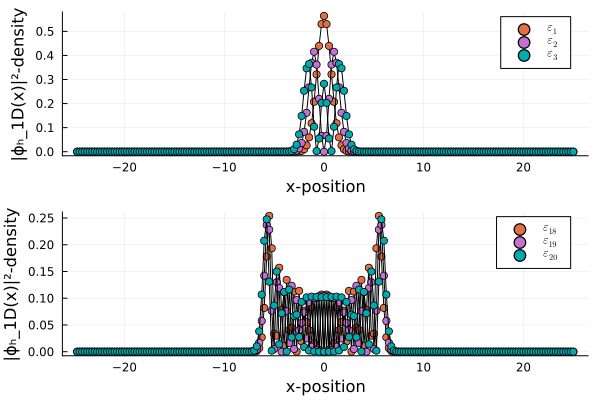

In [42]:
x=[dom_1D[1]+abs(dom_1D[2]-dom_1D[1])*Δxₕ*i for i in 1:convert(Int,1.0/Δxₕ)];
plt=plot();
plot1=plot!(plt,xlabel="x-position",ylabel="|ϕₕ_1D(x)|²-density")
for num_eigenvector in 1:3
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[num_eigenvector],Vₕ_1D);
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/Δxₕ)];
    density=real(conj(fₕ_1D.(pts)).*fₕ_1D.(pts))
    plot1=plot!(plt,x,density,label="",lw=1,lc=:"black")
    plot1=scatter!(plt,x,density,label="\$ \\epsilon_{$(num_eigenvector)}\$",lw=2);
end

plt=plot();
plot2=plot!(plt,xlabel="x-position",ylabel="|ϕₕ_1D(x)|²-density")
for num_eigenvector in (nevₕ-2):nevₕ
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[num_eigenvector],Vₕ_1D);
    pts=[Point(x[i]) for i in 1:convert(Int,1.0/Δxₕ)];
    density=real(conj(fₕ_1D.(pts)).*fₕ_1D.(pts))
    plot2=plot!(plt,x,density,label="",lw=1,lc=:"black")
    plot2=scatter!(plt,x,density,label="\$ \\epsilon_{$(num_eigenvector)}\$",lw=2);
end
plot3=plot(plot1,plot2,layout=(2,1));
display(plot3);
savefig(plot3,path_plots*"density_vs_position_eigenproblem_1D.pdf");

El gráfico anterior corresponde a las autofunciones del Hamiltoniano individual (oscilador armónico unidimensional), más específicamente corresponden a las densidades de probabilidad (módulo cuadrado de las funciones de onda). Si bien se han calculado 20 autofunciones, en el gráfico superior se muestran las primeras tres autofunciones y en el segundo se muestran las últimas tres.

El cálculo de densidad de probabilidad se llevó a cabo de la siguiente forma: $\hat{\rho }( x_{i} ,t_{j}) =\sum _{k=1}^{2}| u_{k}( x_{i} ,t_{j})| ^{2}$

### Escribimos autovectores para visualizar con Visit

In [21]:
write_data=false;
if write_data
    for i in 1:nevₕ
        ϕₕi_1D = ϕₕ_1D[i]; # autovector asociado al autovalor 6
        writevtk(Ω_1D,path_images*"eigenprob_1D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_1D), "phi_imag" => real(ϕₕi_1D)]);
    end
end

### Ahora queremos resolver la dinámica del problema, es decir, la ecuación de evolución (ecuación de Schrödinger dependiente del tiempo) utilizano el método de Euler implícito

Tendremos el siguiente sistema de ecuaciones a resolver,

\begin{align}
     \begin{array}{l}
    \begin{pmatrix}
    \{2\hat{I} -[ \alpha \hat{A} +\alpha _{1}( x_{i})] \Delta t\} & -\beta \Delta t\\
    -\beta \Delta t & \{2\hat{I} -[ \alpha \hat{A} +\alpha _{2}( x_{i})] \Delta t\}
    \end{pmatrix}\begin{pmatrix}
    u_{1}( x_{i} ,t+\Delta t)\\
    u_{2}( x_{i} ,t+\Delta t)
    \end{pmatrix} =\\
    \begin{pmatrix}
    \{2\hat{I} +[ \alpha \hat{A} +\alpha _{1}( x_{i})] \Delta t\} & \beta \Delta t\\
    \beta \Delta t & \{2\hat{I} +[ \alpha \hat{A} +\alpha _{2}( x_{i})] \Delta t\}
    \end{pmatrix}\begin{pmatrix}
    u_{1}( x_{i} ,t)\\
    u_{2}( x_{i} ,t)
    \end{pmatrix}
    \end{array}
\end{align}

Y las formas tensoriales débiles para este caso serán

\begin{align}
    \begin{array}{l}
    a_{1}(( u_{1} ,u_{2}) ,v_{1}) := \int _{\Omega }\{2( u_{1} v_{1}) -[ -\alpha ( \nabla v_{1} \cdotp \nabla u_{1}) +\alpha _{1}( u_{1} v_{1}) +\beta ( u_{2} v_{1})] \Delta t\} d\Omega \\
    a_{2}(( u_{2} ,u_{1}) ,v_{2}) := \int _{\Omega }\{2( u_{2} v_{2}) -[ -\alpha ( \nabla v_{2} \cdotp \nabla u_{2}) +\alpha _{2}( u_{2} v_{2}) +\beta ( u_{1} v_{2})] \Delta t\} d\Omega \\
    \\
    \Rightarrow a(( u_{1} ,v_{1}) ,( u_{2} ,v_{2})) := a_{1}(( u_{1} ,u_{2}) ,v_{1}) +a_{2}(( u_{2} ,u_{1}) ,v_{2})\\
    \\
    \\
    b_{1}( v_{1}) := \int _{\Omega }\left\{2\left( u_{1}^{0} v_{1}\right) +\left[ -\alpha \left( \nabla v_{1} \cdotp \nabla u_{1}^{0}\right) +\alpha _{1}\left( u_{1}^{0} v_{1}\right) +\beta \left( u_{2}^{0} v_{1}\right)\right] \Delta t\right\} d\Omega \\
    b_{2}( v_{2}) := \int _{\Omega }\left\{2\left( u_{2}^{0} v_{2}\right) +\left[ -\alpha \left( \nabla v_{2} \cdotp \nabla u_{2}^{0}\right) +\alpha _{2}\left( u_{2}^{0} v_{2}\right) +\beta \left( u_{1}^{0} v_{2}\right)\right] \Delta t\right\} d\Omega \\
    \\
    \Rightarrow b( v_{1} ,v_{2}) := b_{1}( v_{1}) +b_{2}( v_{2})
    \end{array}
\end{align}

y resolveremos una ecuación del tipo

\begin{align}
    a(( u_{1} ,v_{1}) ,( u_{2} ,v_{2}))\vec{u}( x_{i} ,t_{j}) =b( v_{1} ,v_{2}) \Rightarrow \boxed{\vec{u}( x_{i} ,t_{j}) =\left( a^{-1}\right) b}
\end{align}

y tendremos que resolver un problema de inversión de matrices. Aquí, la forma bilineal $b(v_1,v_2)$ deberá actualizarse en cada paso evolucionado con un nuevo par inicial $\vec{u}^{0} =\left( u_{1}^{0} ,u_{2}^{0}\right)$.

### Defenimos el paso temporal

In [50]:
t₁=0.001;           # final time for test
num_steps=600;      # number of time steps   
n_int=30;           # Intervals where data is saved
Δt=t₁/(num_steps-1) # time step

1.6694490818030051e-6

+ El factor $\frac {\Delta t}{\Delta x^2}$ nos permite corroborar que, si es pequeño $( \lt 1)$, el método de Euler usual funcionaría.
+ El factor $\frac {\Delta t}{\Delta x}$ si es aproximadamente igual a 1, y no usamos métodos implícitos, el método explícito sería intestable.
+ El factor $\left ( \frac {\Delta t}{\Delta x^2} \right)^3$ nos dice cómo escala el error del método implícito.

In [51]:
@printf("Δt/Δx²=%.4f,Δt/Δx=%.4f,Δt³/Δx⁶=%.4f",Δt/(Δxₕ^2),(Δt/Δxₕ),(Δt/(Δxₕ^2))^3)

Δt/Δx²=0.0668,Δt/Δx=0.0003,Δt³/Δx⁶=0.0003

### Creamos espacios de prueba y de solución

In [52]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₁H_1D=TrialFESpace(V₁H_1D,dirichlet_values_1D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
U₂H_1D=TrialFESpace(V₂H_1D,dirichlet_values_1D);
# creamos un campo de espacios
UH_1D = MultiFieldFESpace([U₁H_1D, U₂H_1D]);
VH_1D = MultiFieldFESpace([V₁H_1D, V₂H_1D]);

### Construimos la condición inicial

In [53]:
# u₀ₕ_1D=interpolate_everywhere(ϕₕ_1D[1],Vₕ_1D);
u₀ₕ_1D=interpolate_everywhere(ϕₕ_1D[1],Uₕ_1D);
interp_u₀ₕ_1D=Interpolable(u₀ₕ_1D);

In [54]:
type_BC=1;
if (type_BC==1)
    u₁0H_1D_v₁(x)=0.0;
    u₂0H_1D_v₁=interpolate_everywhere(interp_u₀ₕ_1D,U₂H_1D);
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₁,u₂0H_1D_v₁],UH_1D);
elseif (type_BC==2)
    u₁0H_1D_v₂=interpolate_everywhere(interp_u₀ₕ_1D,U₁H_1D);
    u₂0H_1D_v₂(x)=0.0;
    u₀H_1D=interpolate_everywhere([u₁0H_1D_v₂,u₂0H_1D_v₂],UH_1D);
end

MultiFieldFEFunction():
 num_cells: 10000
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 13696690527193169646

In [55]:
write_data=false
if write_data
    writevtk(Ω_2D,path_images*"evol_ini_dat_$(lpad(0,3,'0'))", cellfields=["u₁0H_2D_re"=>real(u₀H_2D[1]),"u₁0H_2D_im"=>imag(u₀H_2D[1])])
end

@printf("norm L₂u₁=%.6f,norm L₂u₂=%.6f",norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))

norm L₂u₁=0.000000,norm L₂u₂=1.000000

In [56]:
assem_H=SparseMatrixAssembler(UH_1D,VH_1D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_1D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_1D);                   # escribimos u en la base de FE de U

In [57]:
a_H_1D=a_bilineal_forms_2D(α₁,α₂,Δt,dΩ_1D);
mat_contribs_H=a_H_1D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_1D,VH_1D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

In [58]:
t=0;  # inicializamos variable tiempo
write_data=true
if write_data
  # writevtk(Ω_1D,path_images*"evol_1D_01_$(lpad(0,3,'0'))",
  # cellfields=["u₁H_1D_re" => real(u₀H_1D[1]), "u₁H_1D_im" => imag(u₀H_1D[1]),"u₂H_1D_re" => real(u₀H_1D[2]), "u₂H_1D_im" => imag(u₀H_1D[2])])
  writevtk(Ω_1D,path_images*"typeBC1_evol_1D_01_$(lpad(0,3,'0'))",
  cellfields=["u₁H_1D_re" => real(u₀H_1D[1]), "u₁H_1D_im" => imag(u₀H_1D[1]),"u₂H_1D_re" => real(u₀H_1D[2]), "u₂H_1D_im" => imag(u₀H_1D[2])])
  @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))
end

for istep in 1:num_steps
  # println("\n+++ Solving in step $istep of $num_steps +++\n")
  b_H_1D=b_bilineal_form_2D(α₁,α₂,u₀H_1D[1],u₀H_1D[2],Δt,dΩ_1D)

  # descomentar si queremos resolver de forma usual
  # vec_contribs_H=b_H_1D(dv_H[1],dv_H[2])
  vec_contribs_H=b_H_1D(dv_H)
  data_H=collect_cell_vector(VH_1D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)
  x_H = A_H \ b_H
  uH_1D = FEFunction(UH_1D,x_H)

  # descomentar si queremos resolver con solver (NO FUNCIONA)
  # op = Affineassem_HFEOperator(a_H_1D,b_H_1D,UH_1D,VH_1D)
  # ls=LUSolver();solver=LinearFESolver(ls)
  # uH_1D = solve(solver,op)

  u₀H_1D = uH_1D

  t = Δt*istep;

  if ((istep - 1) % n_int == 0) && (istep > 1) && (write_data)
    # writevtk(Ω_1D,path_images*"evol_1D_01_$(lpad(istep,3,'0'))",
    # cellfields=[ "u₁H_1D_re" => real(u₀H_1D[1]), "u₁H_1D_im" => imag(u₀H_1D[1]),"u₂H_1D_re" => real(u₀H_1D[2]), "u₂H_1D_im" => imag(u₀H_1D[2])])
    writevtk(Ω_1D,path_images*"typeBC1_evol_1D_01_$(lpad(istep,3,'0'))",
    cellfields=[ "u₁H_1D_re" => real(u₀H_1D[1]), "u₁H_1D_im" => imag(u₀H_1D[1]),"u₂H_1D_re" => real(u₀H_1D[2]), "u₂H_1D_im" => imag(u₀H_1D[2])])
    @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(u₀H_1D[1],dΩ_1D),norm_L2(u₀H_1D[2],dΩ_1D))
  end
end

t=0.000000,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000052,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000102,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000152,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000202,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000252,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000302,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000352,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000402,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000452,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000503,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000553,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000603,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000653,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000703,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000753,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000803,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000853,norm L₂u₁=0.000000,norm L₂u₂=1.000000


t=0.000903,norm L₂u₁=0.000000,norm L₂u₂=1.000000
t=0.000953,norm L₂u₁=0.000000,norm L₂u₂=1.000000


> useful links to embeded mp4 inside Markdown Julia
 + [https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video](https://developer.mozilla.org/en-US/docs/Web/HTML/Element/video)
 + [https://www.freeconvert.com/mpeg-to-mp4](https://www.freeconvert.com/mpeg-to-mp4)

### Mostramos con visualizador Visit
Acá mostramos la evolución del operador densidad correspondiente a la evolución del vector de estado del problema (resolviendo la ecuación de Schrödinger)

<video controls width="500">
  <source src="./videos/density_pseudocolor_testing_01.mp4" type="video/mp4" />
</video>

Y como podemos observar obtenemos el resultado esperable (resultado trivial) pues, si partimos de un estado inicial de la forma
\begin{align}
  \ket{\psi_0}=\left( \begin{matrix} {\phi_n}\\{0} \end{matrix} \right)
\end{align}
donde $\phi_n$ corresponde a un autoestado del hamiltoniano individual ${\hat h}(x)$ (que en nuestro caso consideramos el estaod fundamental $\phi_{1}$) y al considerar factor de acoplamiento nulo $\gamma=0$ también será un autoestado del hamiltoniano conjunto ${\hat H}(x)$ y la evolución será trivial.

### Ahora probamos hacer lo mismo pero en 2D

#### Primero resolvemos el problema de autovalores

Aquí, de forma análoga al caso 1D, se extiende el problema al caso 2D. Por simplicidad se utiliza la funión `CartesianDiscreteModel` para crear la grilla (elementos cartesianos cuadriláteros regulares). En el código `JupyterNotebook_FinalProject_v2.ipynb` se han probado otros modelos para generar las grillas 2D (con elementos triangulares) y donde es posible cambiar más parámetros para modificar a gusto el grillado.

In [2]:
n_2D=200;dom_2D=(-25.0,25.0,-25.0,25.0);                # cantidad de FE y dominio espacial
partition_2D=(n_2D,n_2D);                             # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos

write_data=false
if write_data
    writevtk(model_2D,path_images*"model_2D");            # escribimos el modelo para visualizar con Visit
end

BCtype="fulldirichlet";
if BCtype=="fulldirichlet"
    println("BCtype = ",BCtype);
    # modified
    labels_2D = get_face_labeling(model_2D);
    add_tag_from_tags!(labels_2D,"D1",[1,7,3,2,4,8]);   # lineas laterales + 4 puntos vértice
    add_tag_from_tags!(labels_2D,"D2",[5,6]);           # lineas superior e inferior
    dirichlet_values_2D=[0.0+im*0.0,0.0+im*0.0];
    dirichlet_tags_2D=["D1","D2"];
end

Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
order_2D=2;reffe_2D=ReferenceFE(lagrangian,Float64,order_2D);

Vₕ_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
Uₕ_2D=TrialFESpace(Vₕ_2D,dirichlet_values_2D);

nevₕ=20;
aₕ_2D,bₕ_2D=bilineal_forms(pₕ,qₕ_2D,rₕ,dΩ_2D);
probₕ_2D=EigenProblem(aₕ_2D,bₕ_2D,Uₕ_2D,Vₕ_2D;nev=nevₕ,tol=10^(-6),maxiter=100,explicittransform=:none,sigma=-1.0)
ϵₕ_2D,ϕₕ_2D=solve(probₕ_2D);

# guardamos los datos para visualización con Visit
write_data=false
if write_data
    for i in 1:nevₕ
        ϕₕi_2D = ϕₕ_2D[i]; # autovector asociado al autovalor i
        writevtk(Ω_2D,path_images*"eigenprob_2D_01_num$(i)",cellfields=["phi_real" => real(ϕₕi_2D), "phi_imag" => real(ϕₕi_2D)]);
    end
end

BCtype = fulldirichlet


### Mostramos salida con visualizador Visit
Acá mostramos la densidad de probabilidad correspondiente a los autoestados del oscilador armónico cuántico bidimensional

<video controls width="500">
  <source src="./videos/eigenstaes2D_testing_02.mp4" type="video/mp4" />
</video>

<video controls width="500">
  <source src="./videos/eigenstaes2D_testing_03.mp4" type="video/mp4" />
</video>

### Ahora resolvemos la dinámica

In [52]:
t₁=0.00001;     # final time for test
num_steps=20; # number of time steps   
n_int=1;      # Intervals where data is 
Δt=t₁/convert(Float64,num_steps-1) # time step

5.263157894736843e-7

In [53]:
@printf("Δt/Δx² = %.4f\nΔt/Δx  = %.4f\nΔt³/Δx⁶= %.4f",Δt/((1.0/n_2D)^2),(Δt/(1.0/n_2D)),(Δt/((1.0/n_2D)^2))^3);

Δt/Δx² = 0.0211
Δt/Δx  = 0.0001
Δt³/Δx⁶= 0.0000

#### Construimos espacios de prueba y de solución

In [54]:
# espacio de pruebas y de soluciones para ψ₁
V₁H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
U₁H_2D=TrialFESpace(V₁H_2D,dirichlet_values_2D);
# espacio de pruebas y de soluciones para ψ₂
V₂H_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
U₂H_2D=TrialFESpace(V₂H_2D,dirichlet_values_2D);
# creamos un campo de espacios
UH_2D = MultiFieldFESpace([U₁H_2D, U₂H_2D]);
VH_2D = MultiFieldFESpace([V₁H_2D, V₂H_2D]);

### Construimos la condición inicial (2D)

In [55]:
u₀ₕ_2D=interpolate_everywhere(ϕₕ_2D[1],Uₕ_2D);
interp_u₀ₕ_2D=Interpolable(u₀ₕ_2D);

u₁0H_2D_v2=interpolate_everywhere(interp_u₀ₕ_2D,U₁H_2D);
u₂0H_2D_v2(x)=0.0;

u₀H_2D=interpolate_everywhere([u₁0H_2D_v2,u₂0H_2D_v2],UH_2D);

write_data=false;
if write_data
    writevtk(Ω_2D,path_images*"evol_ini_dat_$(lpad(0,3,'0'))", cellfields=["u₁0H_2D_re"=>real(u₀H_2D[1]),"u₁0H_2D_im"=>imag(u₀H_2D[1])]);
end

@printf("norm L₂u₁=%.6f,norm L₂u₂=%.6f",norm_L2(u₀H_2D[1],dΩ_2D),norm_L2(u₀H_2D[2],dΩ_2D));

norm L₂u₁=1.000000,norm L₂u₂=0.000000

#### Definimos la formulación débil del problema (formas bi-lineales)

In [56]:
assem_H=SparseMatrixAssembler(UH_2D,VH_2D);       # ensamblamos una matriz sparse con U y V
dv_H=get_fe_basis(VH_2D);                         # escribimos v en la base de FE de V            
du_H=get_trial_fe_basis(UH_2D);                   # escribimos u en la base de FE de U


a_H_2D=a_bilineal_forms_2D(α₁_2D,α₂_2D,Δt,dΩ_2D);
mat_contribs_H=a_H_2D(du_H,dv_H);                       # creamos una matriz de bases (contribuciones)
data_H=collect_cell_matrix(UH_2D,VH_2D,mat_contribs_H); # recolectamos una matriz (datos)
A_H=assemble_matrix(assem_H,data_H);                    # creamos matriz A con contribuciones y datos

### Evolucionamos

In [48]:
write_data=true;

uH_2D=u₀H_2D; # imponemos condición inicial

for istep in 1:num_steps
  
  # escribimos datos
  t = Δt*convert(Float64,istep-1); # tiempo
  if (istep % n_int == 0) && (write_data)
    writevtk(Ω_2D,path_images*"evol_2D_01_$(lpad(istep,3,'0'))",
    cellfields=[ "u₁H_2D_re" => real(uH_2D[1]), "u₁H_2D_im" => imag(uH_2D[1]),"u₂H_2D_re" => real(uH_2D[2]), "u₂H_2D_im" => imag(uH_2D[2])])
    @printf("t=%.6f,norm L₂u₁=%.6f,norm L₂u₂=%.6f\n",t,norm_L2(uH_2D[1],dΩ_2D),norm_L2(uH_2D[2],dΩ_2D))
  end

  b_H_2D=b_bilineal_form_2D(α₁_2D,α₂_2D,u₀H_2D[1],u₀H_2D[2],Δt,dΩ_2D)

  # descomentar si queremos resolver de forma usual
  vec_contribs_H=b_H_2D(dv_H)
  data_H=collect_cell_vector(VH_2D,vec_contribs_H)
  b_H=assemble_vector(assem_H,data_H)
  x_H = A_H \ b_H # invertimos matriz A_H con operador "\"
  uH_2D = FEFunction(UH_2D,x_H)

  # descomentar si queremos resolver con solver específico (NO FUNCIONA)
  # op = Affineassem_HFEOperator(a_H_2D,b_H_2D,UH_2D,VH_2D)
  # ls=LUSolver();solver=LinearFESolver(ls)
  # uH_2D = solve(solver,op)

  u₀H_2D = uH_2D; # actualizamos condición inicial
end

t=0.000000,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000011,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000021,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000032,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000042,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000053,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000063,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000074,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000084,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000095,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000105,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000116,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000126,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000137,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000147,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000158,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000168,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000179,norm L₂u₁=1.000000,norm L₂u₂=0.000000


t=0.000189,norm L₂u₁=1.000000,norm L₂u₂=0.000000
t=0.000200,norm L₂u₁=1.000000,norm L₂u₂=0.000000


Nota: Si bien el problema de autovalores para 1D y 2D funciona correctamente, el problema de la evolución temporal funciona sólamente para el caso 1D. Es decir, este último resultado mostrado no arroja los resultados esperables, para ello escribimos el código `Testing_03_SignleEigenProblemAndImplicitMethod.ipynb` para testear las problemáticas y tratar de solucionar este problema.

Además, debemos notar que, posiblemente el caso 1D nos parezca que funciona correctamente porque se ha evolucionado poco tiempo, lo cual podríamos estar observando el sistema por un tiempo tan corto que no da lugar a la evolución propiamente dicha. Estas cuestiones se detallan mejor en el código `Testing_03_SignleEigenProblemAndImplicitMethod.ipynb` donde hemos llevado a cabo análisis de error, análisis dimensional y formulación correcta de las soluciones débiles al problema de evolución.